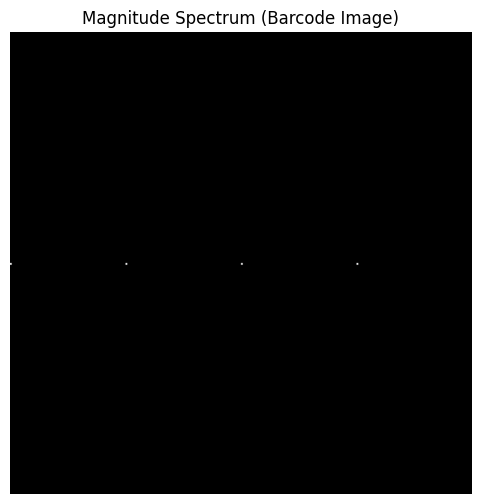

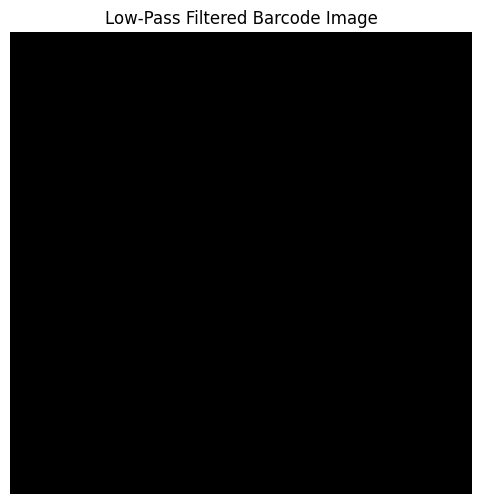

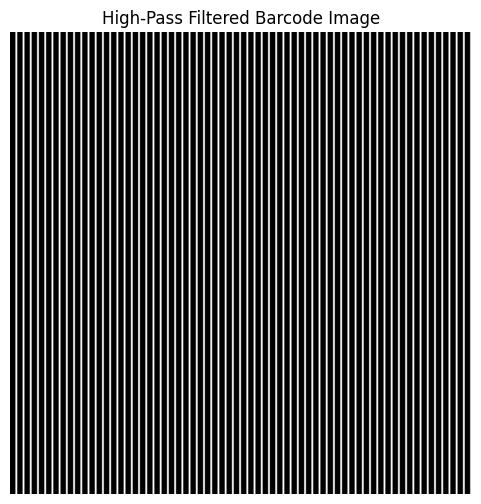

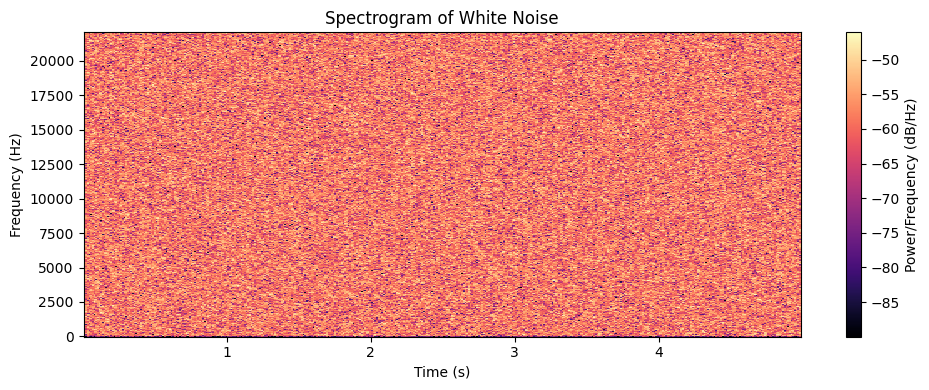

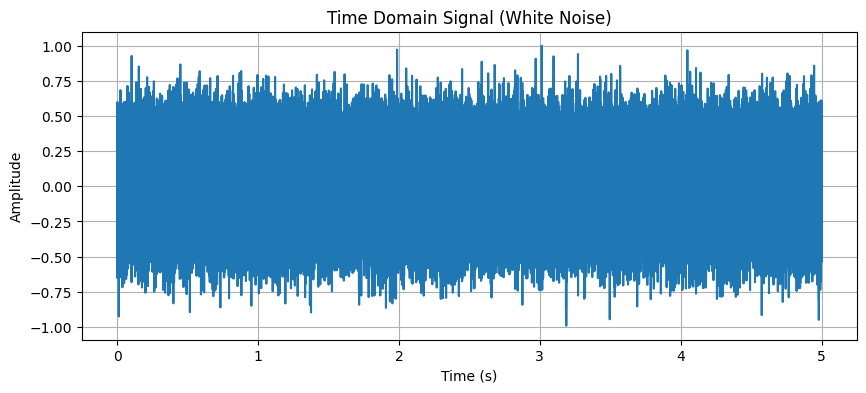

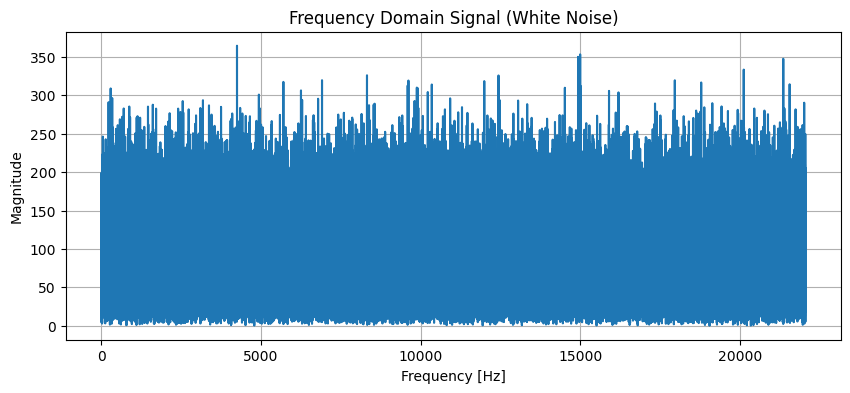

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.io.wavfile import write
from scipy.signal import spectrogram

# Image: Barcode
def generate_barcode(rows=256, cols=256, bars=60):
    img = np.ones((rows, cols), dtype=np.uint8) * 255
    for i in range(0, cols, cols // bars):
        cv2.rectangle(img, (i, 0), (i + cols // (2 * bars), rows), 0, -1)
    cv2.imwrite('barcode.png', img)
    return img

# Audio: White noise
def generate_white_noise(duration=5, fs=44100):
    noise = np.random.normal(0, 1, int(fs * duration))
    noise_normalized = noise / np.max(np.abs(noise)) if np.max(np.abs(noise)) != 0 else noise
    write('white_noise.wav', fs, (noise_normalized * 32767).astype(np.int16))
    return noise_normalized, fs

image = generate_barcode()
audio_signal, audio_sr = generate_white_noise()


# Load image in grayscale
image_float = np.float32(image)

# Compute 2D FFT
f = np.fft.fft2(image_float)
fshift = np.fft.fftshift(f) # Shift zero freq. to center

# Compute magnitude spectrum
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

# Display Magnitude Spectrum
plt.figure(figsize=(6,6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum (Barcode Image)')
plt.axis('off')
plt.show()

# Apply a Low-Pass and High-Pass Filter in the Frequency Domain
rows, cols = image.shape
crow, ccol = rows // 2 , cols // 2

# Create a low-pass filter mask (circle in the center)
mask_lp = np.zeros((rows, cols), np.uint8)
r = 30 # Radius
cv2.circle(mask_lp, (ccol, crow), r, 1, thickness=-1)

# Create high-pass mask as complement
mask_hp = 1 - mask_lp

# Apply the masks
fshift_lp = fshift * mask_lp
fshift_hp = fshift * mask_hp

# Reconstruct the Image from the Filtered Spectrum
# Inverse shift and IFFT for low-pass
f_ishift_lp = np.fft.ifftshift(fshift_lp)
img_back_lp = np.fft.ifft2(f_ishift_lp)
img_back_lp = np.abs(img_back_lp)

# Display the result
plt.figure(figsize=(6,6))
plt.imshow(img_back_lp, cmap='gray')
plt.title('Low-Pass Filtered Barcode Image')
plt.axis('off')
plt.show()

# Inverse shift and IFFT for high-pass
f_ishift_hp = np.fft.ifftshift(fshift_hp)
img_back_hp = np.fft.ifft2(f_ishift_hp)
img_back_hp = np.abs(img_back_hp)

# Display the result
plt.figure(figsize=(6,6))
plt.imshow(img_back_hp, cmap='gray')
plt.title('High-Pass Filtered Barcode Image')
plt.axis('off')
plt.show()

f_spec, t_spec, Sxx = spectrogram(audio_signal, fs=audio_sr, nperseg=1024, noverlap=512)

# Convert power spectrogram to dB for visualization
Sxx_db = 10 * np.log10(Sxx + 1e-9)

# Display spectrogram
plt.figure(figsize=(10, 4))
plt.pcolormesh(t_spec, f_spec, Sxx_db, cmap='magma')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Spectrogram of White Noise')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

# Plot waveform (time domain)
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(audio_signal)/audio_sr, len(audio_signal)), audio_signal)
plt.title('Time Domain Signal (White Noise)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot magnitude spectrum (frequency domain)
Y_fft = np.fft.fft(audio_signal)
freqs = np.fft.fftfreq(len(audio_signal), 1/audio_sr)
plt.figure(figsize=(10, 4))
plt.plot(freqs[:len(freqs)//2], np.abs(Y_fft[:len(Y_fft)//2]))
plt.title('Frequency Domain Signal (White Noise)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()